# **Preprocess Data and Create Labels and Features**

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras.utils import to_categorical
import tensorflow as tf
import numpy as np
import os
import cv2 as cv
import mediapipe as mp
from matplotlib import pyplot as plt
from mediapipe.python.solutions.pose import PoseLandmark

In [18]:
#FOR UPGRADED SEQUENCE
# DATA_PATH = os.path.join('Sign_Data_Upgrade')
DATA_PATH = os.path.join('My_Datasets')

actions = np.array(['terimakasih', 'tolong'])

# actions = np.array(['terimakasih'])

# actions = np.array(['maaf', 'tolong', "terimakasih", "nama", "saya", "kamu", "siapa"])

# menggunakan xx video
no_sequences = 30

# setiap video berisi 30 frame
sequence_length = 30

In [19]:
label_map = {label:num for num, label in enumerate(actions)}

In [20]:
label_map

{'terimakasih': 0, 'tolong': 1}

In [21]:
sequences, labels = [], []
for action in actions:
    for sequence in np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int):
        window = []
        for frame_num in range(sequence_length):
            # res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num + 1)))
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}-norm.npy".format(frame_num + 1)))
            
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [22]:
np.array(sequences).shape

(60, 30, 108)

In [23]:
X = np.array(sequences)
y = to_categorical(labels).astype(int)

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [25]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(48, 30, 108)
(12, 30, 108)
(48, 2)
(12, 2)


# **Build and Train LSTM Neural Network**

In [66]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint

In [67]:
checkpoint = ModelCheckpoint('model.h5', monitor='categorical_accuracy', verbose=1, mode = 'max', save_best_only=True, save_weights_only=False,save_freq='epoch')

In [68]:
# SIMPLE MODEL -> MAIN MODEL
model = Sequential()

model.add(LSTM(64, return_sequences=False, activation='tanh', input_shape=(30,108)))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

In [90]:
# COMPLEX MODEL -> EXPERIMENTAL
# model = Sequential()

# model.add(LSTM(128, return_sequences=True, activation='tanh', input_shape=(30,108)))
# model.add(LSTM(64, return_sequences=True, activation='tanh'))
# model.add(LSTM(32, return_sequences=False, activation='tanh'))
# model.add(Dropout(0.4))
# model.add(Dense(32, activation='relu'))
# model.add(Dense(32, activation='relu'))
# model.add(Dense(actions.shape[0], activation='softmax'))

In [69]:
# COMPLEX MODEL 2

# model = Sequential()

# model.add(LSTM(128, return_sequences=True, activation='tanh', input_shape=(30,108)))
# model.add(LSTM(64, return_sequences=True, activation='tanh'))
# model.add(LSTM(32, return_sequences=False, activation='tanh'))
# model.add(Dropout(0.5))
# model.add(Dense(actions.shape[0], activation='softmax'))

In [70]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 64)                44288     
                                                                 
 dense_12 (Dense)            (None, 64)                4160      
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_13 (Dense)            (None, 2)                 130       
                                                                 
Total params: 48578 (189.76 KB)
Trainable params: 48578 (189.76 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [71]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [72]:
train_model = model.fit(X_train, y_train, epochs=10, callbacks=[checkpoint], validation_data=(X_test, y_test))

Epoch 1/10
1/2 [==============>...............] - ETA: 1s - loss: 0.8790 - categorical_accuracy: 0.4062
Epoch 1: categorical_accuracy improved from -inf to 0.56250, saving model to model.h5
2/2 [==============================] - 2s 465ms/step - loss: 0.7281 - categorical_accuracy: 0.5625 - val_loss: 0.6236 - val_categorical_accuracy: 0.3333
Epoch 2/10
1/2 [==============>...............] - ETA: 0s - loss: 0.5707 - categorical_accuracy: 0.6562
Epoch 2: categorical_accuracy improved from 0.56250 to 0.75000, saving model to model.h5
2/2 [==============================] - 0s 67ms/step - loss: 0.4796 - categorical_accuracy: 0.7500 - val_loss: 0.4856 - val_categorical_accuracy: 0.8333
Epoch 3/10
1/2 [==============>...............] - ETA: 0s - loss: 0.4011 - categorical_accuracy: 0.8438
Epoch 3: categorical_accuracy improved from 0.75000 to 0.89583, saving model to model.h5
2/2 [==============================] - 0s 77ms/step - loss: 0.3525 - categorical_accuracy: 0.8958 - val_loss: 0.3679 - 

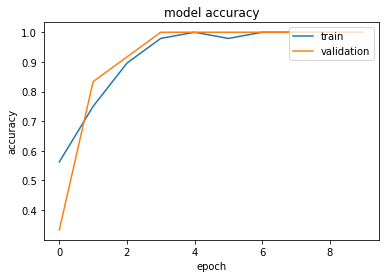

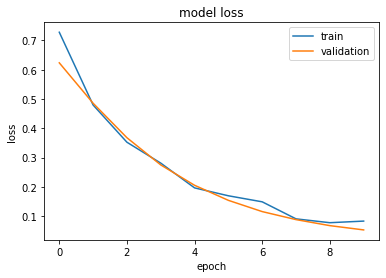

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 64)                44288     
                                                                 
 dense_12 (Dense)            (None, 64)                4160      
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_13 (Dense)            (None, 2)                 130       
                                                                 
Total params: 48578 (189.76 KB)
Trainable params: 48578 (189.76 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [73]:
# print(train_model.history.keys())

plt.plot(train_model.history['categorical_accuracy'])
plt.plot(train_model.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

plt.plot(train_model.history['loss'])
plt.plot(train_model.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

# score, acc = model.evaluate(X_test,y_test,batch_size=32,verbose=0)
# print('Test performance: accuracy={0}, loss={1}'.format(acc, score)) 
# print(X_train.shape, X_test.shape)
# print(y_train.shape, y_test.shape)
    
model.summary()

In [ ]:
model.save('model.h5')

# **Make Predictions**

In [24]:
res = model.predict(X_test)

1/1 [==============================] - 1s 600ms/step


In [25]:
actions[np.argmax(res[10])]

'tolong'

In [26]:
actions[np.argmax(y_test[10])]

'tolong'

# **Save Weights**

In [27]:
model.save('model.h5')

In [96]:
del model

In [170]:
model.load_weights('model.h5')

# **Evaluation using Confusion Matrix and Accuracy**

In [171]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_multilabel_classification
from sklearn.tree import DecisionTreeClassifier
import seaborn as sn

In [172]:
yhat = model.predict(X_test)

1/1 [==============================] - 0s 31ms/step


In [173]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [174]:
confusion_matrix = multilabel_confusion_matrix(ytrue, yhat)
print(confusion_matrix)

[[[10  0]
  [ 0  8]]

 [[ 8  0]
  [ 0 10]]]


In [175]:
# sn.heatmap(confusion_matrix, annot=True, fmt='g')
# plt.show()

ValueError: Must pass 2-d input. shape=(2, 2, 2)

In [55]:
accuracy_score(ytrue, yhat)

1.0